In [1]:
import pyro
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from typing import Tuple, Callable
from collections import Counter
from tqdm import tqdm

sns.set_theme(style="darkgrid")

# Practice Chapter 3

## Easy

These problems use the samples from the posterior distribution for the globe tossing example. This code will give you a specific set of samples, so that you can check your answers exactly.
```
p_grid <- seq( from=0 , to=1 , length.out=1000 )
prior <- rep( 1 , 1000 )
likelihood <- dbinom( 6 , size=9 , prob=p_grid )
posterior <- likelihood * prior
posterior <- posterior / sum(posterior)
set.seed(100)
samples <- sample( p_grid , prob=posterior , size=1e4 , replace=TRUE )
```
Use the values in samples to answer the questions that follow.

### 3E1

How much posterior probability lies below p = 0.2?

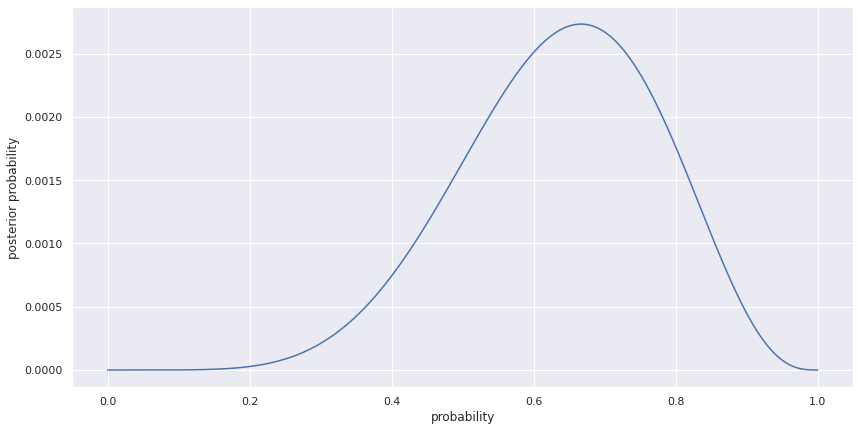

In [2]:
def plot_posterior(p: np.array, posterior: np.array, label: str = None) -> None:
    sns.lineplot(
        x="probability",
        y="posterior probability",
        label=label,
        data={
            'probability': p,
            'posterior probability': posterior,
        },
    )

def globe_model(
    W: int,
    L: int,
    num_grid_points: int = 1000,
    prior_func: Callable = lambda x: 1
) -> Tuple[torch.tensor, torch.tensor]:
    p_grid = torch.tensor(np.linspace(0, 1, num=num_grid_points))
    prior =  torch.tensor([prior_func(p) for p in p_grid])
    log_likelihood =pyro.distributions.Binomial(
        torch.tensor(float(W + L)), probs=p_grid).log_prob(torch.tensor(float(W))
    )
    posterior = torch.exp(log_likelihood) * prior
    posterior = posterior / torch.sum(posterior)
    return p_grid, posterior

p_grid, posterior = globe_model(6, 3)

num_samples = 10**4
samples = np.random.choice(p_grid, size=num_samples, replace=True, p=posterior)

plt.figure(figsize=(14, 7))
plot_posterior(p_grid, posterior)

In [3]:
np.sum(samples < 0.2) / num_samples

0.0007

### 3E2

How much posterior probability lies above p = 0.8?

In [4]:
np.sum(samples > 0.8) / num_samples

0.1216

### 3E3

How much posterior probability lies between p = 0.2 and p = 0.8?

In [5]:
np.sum(np.logical_and(samples < 0.8, samples > 0.2)) / num_samples

0.8777

### 3E4

20% of the posterior probability lies below which value of p?

In [6]:
samples_sorted = sorted(samples)

In [7]:
samples_sorted[int(0.2*num_samples)]

0.5235235235235235

### 3E5
20% of the posterior probability lies above which value of p?

In [8]:
samples_sorted[int(0.8*num_samples)]

0.7627627627627628

### 3E6

Which values of p contain the narrowest interval equal to 66% of the posterior probability?

In [9]:
def HPDI(probability_samples: list, p=0.83) -> Tuple[float, float]:
    num_samples = len(probability_samples)
    samples_sorted = sorted(probability_samples)
    intervals = [
        (samples_sorted[int(p*num_samples) + i], samples_sorted[i])
        for i in range(num_samples - int(p*num_samples))
    ]

    return sorted(intervals, key=lambda x: x[0] - x[1])[0]

In [10]:
HPDI(samples_sorted, p=0.66)

(0.7957957957957957, 0.5305305305305306)

### 3E7

Which values of p contain 66% of the posterior probability, assuming equal posterior probability both below and above the interval?

In [11]:
samples_sorted[int(0.34 / 2 * num_samples)], samples_sorted[int((1 - 0.34 / 2) * num_samples)]

(0.5065065065065065, 0.7767767767767768)

## Medium

### 3M1
Suppose the globe tossing data had turned out to be 8 water in 15 tosses. Construct the posterior distribution, using grid approximation. Use the same flat prior as before.

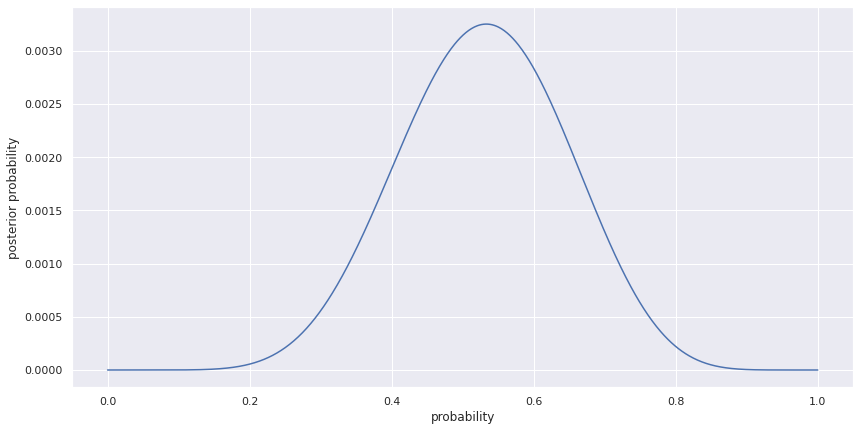

In [12]:
p_grid, posterior = globe_model(8, 15 - 8)

plt.figure(figsize=(14, 7))
plot_posterior(p_grid, posterior)

### 3M2

Draw 10,000 samples from the grid approximation from above. Then use the samples to calculate the 90% HPDI for p.

In [13]:
num_samples = 10**4
samples = np.random.choice(p_grid, size=num_samples, replace=True, p=posterior)

samples_sorted = sorted(samples)

HPDI(samples_sorted, p=0.9)

(0.7217217217217217, 0.34134134134134136)

### 3M3

Construct a posterior predictive check for this model and data. This means simulate the distribution of samples, averaging over the posterior uncertainty in p. What is the probability of observing 8 water in 15 tosses?

In [14]:
def simulation(p_grid: list, posterior: list, tosses) -> dict:
    num_prob_samples = 5*10**3
    num_samples = 42
    prob_samples = np.random.choice(
        p_grid, size=num_prob_samples, replace=True, p=posterior
    )

    sample_dist = Counter()
    for p in tqdm(prob_samples):
        for i in range(num_samples):
            sample_dist[int(pyro.distributions.Binomial(
                tosses, probs=p
            ).sample().item())] += 1
    sample_dist = [
        (k, v / (num_prob_samples * num_samples)) for k, v in sample_dist.items()
    ]
    return dict(sorted(sample_dist, key=lambda x: x[0]))

In [15]:
simulation_result = simulation(p_grid, posterior, 15)

100%|██████████| 5000/5000 [00:18<00:00, 263.47it/s]


<AxesSubplot:>

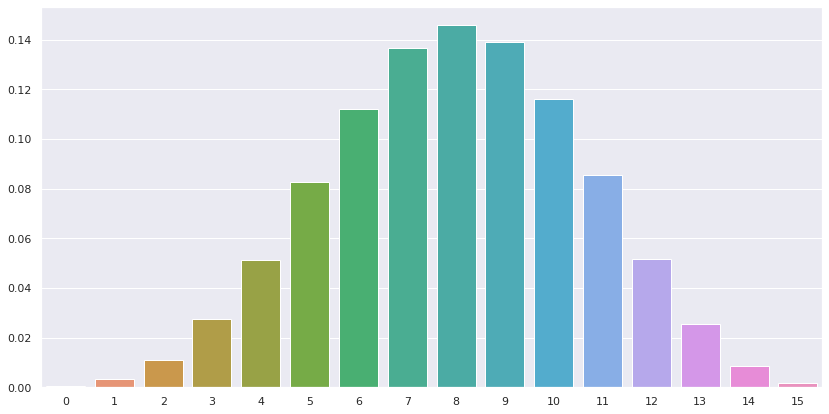

In [16]:
plt.figure(figsize=(14, 7))
sns.barplot(
    x=list(simulation_result.keys()), y=list(simulation_result.values())
)

In [17]:
simulation_result[8]

0.1459904761904762

### 3M4

Using the posterior distribution constructed from the new (8/15) data, now calculate the probability of observing 6 water in 9 tosses.

In [18]:
simulation_result = simulation(p_grid, posterior, 9)

100%|██████████| 5000/5000 [00:18<00:00, 266.61it/s]


<AxesSubplot:>

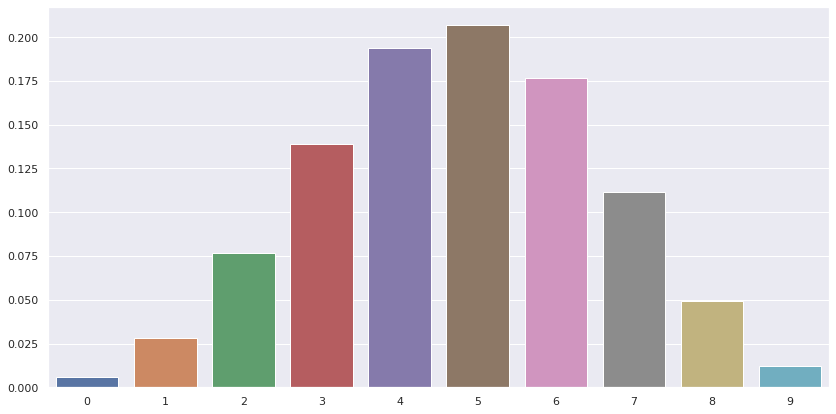

In [19]:
plt.figure(figsize=(14, 7))
sns.barplot(
    x=list(simulation_result.keys()), y=list(simulation_result.values())
)

In [20]:
simulation_result[6]

0.1766761904761905

### 3M5

Start over at **3M1**, but now use a prior that is zero below p = 0.5 and a constant above p = 0.5. This corresponds to prior information that a majority of the Earth’s surface is water. Repeat each problem above and compare the inferences. What difference does the better prior make? If it helps, compare inferences (using both priors) to the true value p = 0.7.

In [21]:
def step_func(x, x_0: float = 0.5):
    return 0 if x < x_0 else 1

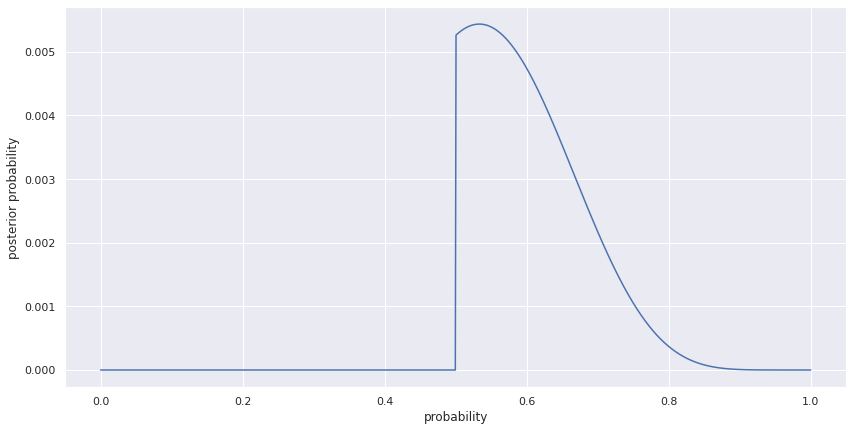

In [22]:
p_grid, posterior = globe_model(8, 15 - 8, prior_func=step_func)

plt.figure(figsize=(14, 7))
plot_posterior(p_grid, posterior)

In [23]:
num_samples = 10**4
samples = np.random.choice(p_grid, size=num_samples, replace=True, p=posterior)

samples_sorted = sorted(samples)

HPDI(samples_sorted, p=0.9)

(0.7127127127127127, 0.5005005005005005)

In [24]:
simulation_result = simulation(p_grid, posterior, 15)

100%|██████████| 5000/5000 [00:19<00:00, 258.61it/s]


<AxesSubplot:>

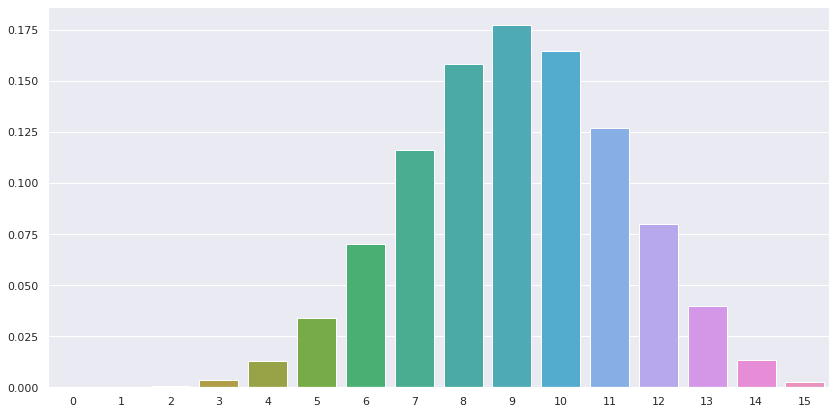

In [25]:
plt.figure(figsize=(14, 7))
sns.barplot(
    x=list(simulation_result.keys()), y=list(simulation_result.values())
)

In [26]:
simulation_result[8]

0.15805714285714287

In [27]:
simulation_result = simulation(p_grid, posterior, 9)

100%|██████████| 5000/5000 [00:19<00:00, 261.83it/s]


<AxesSubplot:>

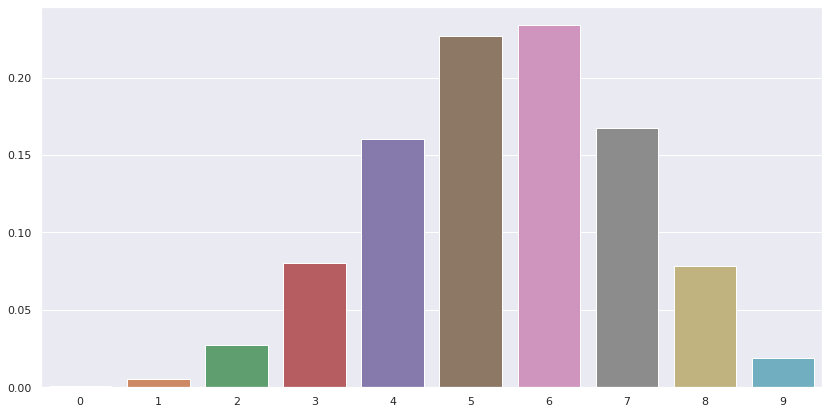

In [28]:
plt.figure(figsize=(14, 7))
sns.barplot(
    x=list(simulation_result.keys()), y=list(simulation_result.values())
)

In [29]:
simulation_result[6]

0.23402380952380952

**Note**: What we find is that the new prior moves the probabilities to results which are closer to (the true) 0.7 than to the observation with just 15 tosses.

### 3M6

Suppose you want to estimate the Earth’s proportion of water very precisely. Specifically, you want the 99% percentile interval of the posterior distribution of p to be only 0.05 wide. This means the distance between the upper and lower bound of the interval should be 0.05. How many times will you have to toss the globe to do this?

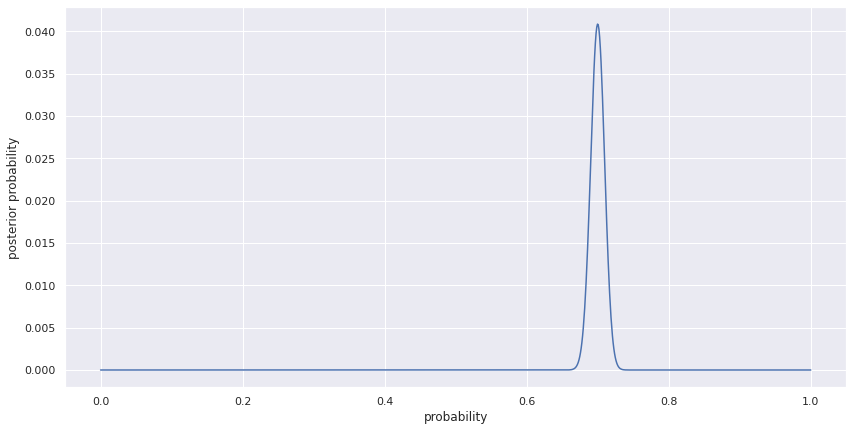

In [30]:
num_globe_tosse = 2.2*10**3
p_grid, posterior = globe_model(
    0.7 * num_globe_tosse, (1 - 0.7) * num_globe_tosse
)
plt.figure(figsize=(14, 7))
plot_posterior(p_grid, posterior)

In [31]:
num_samples = 10**4
samples = np.random.choice(p_grid, size=num_samples, replace=True, p=posterior)

samples_sorted = sorted(samples)

boundaries = HPDI(samples_sorted, p=0.99)
boundaries[0] - boundaries[1]

0.05005005005005003

## Hard

Introduction. The practice problems here all use the data below. These data indicate the gender (male=1, female=0) ofofficially reported first and second born children in 100 two-child families.
```
birth1 <- c(1,0,0,0,1,1,0,1,0,1,0,0,1,1,0,1,1,0,0,0,1,0,0,0,1,0, 0,0,0,1,1,1,0,1,0,1,1,1,0,1,0,1,1,0,1,0,0,1,1,0,1,0,0,0,0,0,0,0, 1,1,0,1,0,0,1,0,0,0,1,0,0,1,1,1,1,0,1,0,1,1,1,1,1,0,0,1,0,1,1,0, 1,0,1,1,1,0,1,1,1,1)

birth2 <- c(0,1,0,1,0,1,1,1,0,0,1,1,1,1,1,0,0,1,1,1,0,0,1,1,1,0, 1,1,1,0,1,1,1,0,1,0,0,1,1,1,1,0,0,1,0,1,1,1,1,1,1,1,1,1,1,1,1,1, 1,1,1,0,1,1,0,1,1,0,1,1,1,0,0,0,0,0,0,1,0,0,0,1,1,0,0,1,0,0,1,1, 0,0,0,1,1,1,0,0,0,0)
```
So for example, the first family in the data reported a boy (1) and then a girl (0). The second family reported a girl (0) and then a boy (1). The third family reported two girls. You can load these two vectors into R’s memory by typing:
```
library(rethinking) data(homeworkch3)
```
Use

Use these vectors as data. So for example to compute the total number ofboys born across all ofthese births, you could use:
```
sum(birth1) + sum(birth2)
[1] 111
```


### 3H1

Using grid approximation, compute the posterior distribution for the probability of a birth being a boy. Assume a uniform prior probability. Which parameter value maximizes the posterior probability?

### 3H2

Using the sample function, draw 10,000 random parameter values from the posterior distri- bution you calculated above. Use these samples to estimate the 50%, 89%, and 97% highest posterior density intervals.

### 3H3

Use rbinom to simulate 10,000 replicates of 200 births. You should end up with 10,000 num- bers, each one a count of boys out of 200 births. Compare the distribution of predicted numbers of boys to the actual count in the data (111 boys out of 200 births). There are many good ways to visualize the simulations, but the dens command (part of the rethinking package) is probably the easiest way in this case. Does it look like the model fits the data well? That is, does the distribution ofpredictions include the actual observation as a central, likely outcome?

### 3H4

Nowcompare 10,000 counts ofboys from100 simulated first borns only to the number ofboys in the first births, birth1. How does the model look in this light?

### 3H5

The model assumes that sex of first and second births are independent. To check this assump- tion, focus now on second births that followed female first borns. Compare 10,000 simulated counts of boys to only those second births that followed girls. To do this correctly, you need to count the number of first borns who were girls and simulate that many births, 10,000 times. Compare the counts ofboys in your simulations to the actual observed count ofboys following girls. How does the model look in this light? Any guesses what is going on in these data?